# TSNE embeddings for the monthly data comments from subreddits

# IMPORT MODULES

In [3]:
#import json
import os
#from google.colab import drive
from tqdm.notebook import tqdm
import pickle
from collections import Counter
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import spatial

import umap
import matplotlib.pyplot as plt

# import torch
# from sentence_transformers import SentenceTransformer, util
#from sklearn.metrics.pairwise import cosine_similarity
# from sklearn.decomposition import PCA
# from sklearn.manifold import TSNE
# from sklearn.cluster import KMeans
# from sklearn.cluster import OPTICS
# import seaborn as sns

# TECHNICAL FUNCTIONS

In [4]:
def get_date_range(month_start, year_start, month_end, year_end):
    from itertools import cycle
    month_range = list(range(1,13))
    cycle_month_range = cycle(month_range)
    while True:
        current_month = next(cycle_month_range)
        if current_month == month_start:
            break
    date_tuples = []
    year = year_start
    while True:
        date_tuples.append((current_month, year))
        if year == year_end and current_month == month_end:
            break
        current_month = next(cycle_month_range)
        if current_month == 1:
            year += 1
    return date_tuples

# UPLOAD DATA

In [5]:
google_drive_path = "/Users/amedvede/Google Drive/"
comptech_opinion_analizer_path = os.path.join(google_drive_path, "comptech_opinion_analizer")

In [12]:
# UPLOAD THE DATA

data_dir = os.path.join(comptech_opinion_analizer_path, "code/embeddings_bert/")
data_files = [f for f in os.listdir(data_dir) if "pickle" in f]

entity = "JoeBiden"
entity_data_files = sorted([f for f in data_files if entity in f])

df_vecs = pd.DataFrame()
for f in tqdm(entity_data_files):
    data_path = os.path.join(data_dir, f)
    df_vecs = df_vecs.append(pickle.load(open(data_path, "rb")))

# Show the timeline of comment counts



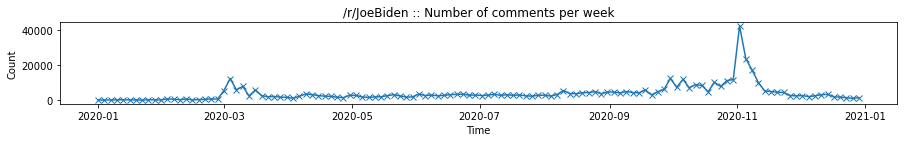

In [5]:
created_list = sorted(df_vecs.created_utc.to_list())
b_width = 3600*24*3 # weekly
bins = np.arange(min(created_list), max(created_list) + 1, b_width)
hist, bins = np.histogram(created_list, bins = bins)
dt_bins = [datetime.fromtimestamp(t) for t in bins[:-1]]

plt.figure(figsize=(15,1.5))
plt.title(f"/r/{entity} :: Number of comments per week")
plt.plot(dt_bins, hist, marker = "x")
plt.xlabel("Time")
plt.ylabel("Count")
plt.show()

# UMAP EMBEDDING OF COMMENTS

# !!!!  VISUALISATION OF EMBEDDINGS IS BELOW  !!!!

In [6]:
# ADD FOLDER
# colab_notebooks_path = os.path.join(google_drive_path, "Colab Notebooks/opinion_analyzer/")
umap_embedding_dir = os.path.join(comptech_opinion_analizer_path, "data/umap_embeddings")
os.makedirs(umap_embedding_dir, exist_ok = True)

In [42]:
# DIMENSIONALITY REDUCTION FOR ALL MONTHLY DATA
date_range = get_date_range(1, 2020, 1, 2021)
min_dist = 0.001
for my_start, my_end in tqdm(list(zip(date_range, date_range[1:]))):
    # PREPARATIONS
    dt_start = datetime(my_start[1], my_start[0], 1)
    dt_end = datetime(my_end[1], my_end[0], 1)

    month_str = dt_start.strftime("%b %Y")
    t_start, t_end = dt_start.timestamp(), dt_end.timestamp()

    month_vecs_df = df_vecs[(t_start < df_vecs.created_utc ) & (df_vecs.created_utc < t_end)]

    month_embeddings = month_vecs_df.embedding.to_list()
    month_labels = month_vecs_df.body.to_list()
    month_ids = month_vecs_df.link_id.to_list()
    print(f"Month labels {len(month_labels)}")
    
    # UMAP 
    embedder = umap.UMAP(min_dist = min_dist, metric = "cosine")
    month_embeddings_2d = embedder.fit_transform(month_embeddings)
    
    # OUTPUT 
    out_file = f"umap_embedding_2d_{entity}_{my_start[0]}_{my_start[1]}_min_dist_{round(min_dist, 2)}.pickle"
    out_path = os.path.join(umap_embedding_dir, out_file)
    out_pack = (month_ids, month_labels, month_embeddings_2d)
    pickle.dump(out_pack, open(out_path, "wb"))

Month labels 3273
Month labels 6160
Month labels 49957
Month labels 23545
Month labels 24442
Month labels 31220
Month labels 30461
Month labels 41014
Month labels 52231
Month labels 92640
Month labels 121206
Month labels 23361



# Visualisation of comments each month

In [13]:
google_drive_path = "/Users/amedvede/Google Drive/"
comptech_opinion_analizer_path = os.path.join(google_drive_path, 
                                              "comptech_opinion_analizer")
umap_embedding_dir = os.path.join(comptech_opinion_analizer_path, "data/umap_embeddings")

In [16]:
target_month = 6

dt_start = datetime(2020, target_month, 1)
dt_end = datetime(2020, target_month+1, 1)

dt_str = dt_start.strftime("%b %Y")
dt_month = int(dt_start.strftime("%m"))
dt_year = int(dt_start.strftime("%Y"))

t_start, t_end = dt_start.timestamp(), dt_end.timestamp()

In [17]:
entity = "JoeBiden"
min_dist = 0.001
embedding_file = f"umap_embedding_2d_{entity}_{dt_month}_{dt_year}_min_dist_{round(min_dist, 2)}.pickle"
embedding_path = os.path.join(umap_embedding_dir, embedding_file)
(month_ids, month_labels, month_embeddings_2d) = pickle.load(open(embedding_path, "rb"))

In [18]:
month_labels_short = [s[:60]+"..." if len(s)>60 else s for s in month_labels]
len(month_labels_short)

31220

In [ ]:
# VISUALISATION
import plotly.graph_objects as go

marker_style = dict(color='lightblue', size=6,  line=dict(color='black', width = 0.5))

X, Y = zip(*month_embeddings_2d)
scatter_gl = go.Scattergl(x = X, y = Y, hovertext = month_labels_short, mode='markers', marker= marker_style)

fig = go.Figure(data = scatter_gl)
fig.update_layout(width=1000, height=700, plot_bgcolor = "white", margin=dict(l=10, r=10, t=30, b=10), 
                  title=f"UMAP comments /r/{entity} :: period {dt_str}")
fig.show()